# **気象予報データ全てを用いて翌日の05:30 ~ 18:30までの発電量をMLPで予測する(まとめての予測ではなく時間帯を分ける)**

# **共通の変数が多すぎてダメだった**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os
from new_MLP import MLP

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [5]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [6]:
def get_output_data(Y):
    '''
    全時系列データから05:30 ~ 18:30までのデータごとに分割する
    他のipynbとは違う関数であることに注意
    発電量がないところはそもそも予測しないことにする
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48+10):(i*48+37)]
        reshaped = each_data.reshape(27)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [7]:
def process_output_data(Y):
    '''
    取り除いて時間を足し戻す
    返り値は一次元配列
    '''
    Y = np.array(Y)
    Y_s = []
    for i in range(len(Y)):
        tmp = [0,0,0,0,0,0,0,0,0,0]+list(Y[i])+[0,0,0,0,0,0,0,0,0,0,0]
        Y_s.append(tmp)
    Y_s = np.array(Y_s)
    Y_s = Y_s.reshape(Y_s.shape[0] *Y_s.shape[1])
    return Y_s

In [8]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [9]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [10]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [11]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

In [12]:
def wv_to_sin(x):
    '''
    漢字になってる風向データをsinになおす
    '''
    if x == "北":
        return -1.0
    elif x == "北西":
        return -0.5
    elif x == "西":
        return 0.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 1.0
    elif x == "南東":
        return 0.5
    elif x == "東":
        return 0
    else:
        return -0.5

In [13]:
def wv_to_cos(x):
    '''
    漢字になってる風向データをcosになおす
    '''
    
    if x == "北":
        return 0.0
    elif x == "北西":
        return 0.5
    elif x == "西":
        return 1.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 0.0
    elif x == "南東":
        return -0.5
    elif x == "東":
        return -1.0
    else:
        return -0.5

In [14]:
def scaling_output(output_30):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [65]:
def add_time_data(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['month'] = input_data[key].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour'] = input_data[key].map(lambda x: int(x.month))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['month', 'hour'], axis=1)
    return input_data

### **データの準備**

In [15]:
target_place = 1

In [16]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]

In [17]:
output_30 = scaling_output(output_30)

In [48]:
# 天気予報のデータを実は今まで使ってなかった
if target_place == 1 or target_place == 2:
    fc_data = pd.read_csv('data/raw_data/forecast_kanagawa.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    fc_data = pd.read_csv('data/raw_data/forecast_yamanashi.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [49]:
# 各降水確率, 各時間帯の天気, 気温のみを選択
fc_data = fc_data.drop(['weather', 'weather_detail', 'wind', 'wave'], axis=1)

In [50]:
hours = ['we_00-03', 'we_03-06', 'we_06-09', 'we_09-12', 'we_12-15', 'we_15-18', 'we_18-21', 'we_21-24']
for hour in hours:
    dummy_df = pd.get_dummies(fc_data[[hour]])
    fc_data = pd.concat([fc_data, dummy_df], axis=1, join='inner')
    fc_data= fc_data.drop([hour], axis=1)

In [51]:
hours = ['wv_00-03', 'wv_03-06', 'wv_06-09', 'wv_09-12', 'wv_12-15', 'wv_15-18', 'wv_18-21', 'wv_21-24']
for hour in hours:
    fc_data[hour+'_cos'] = fc_data[hour].map(lambda x:wv_to_cos(x))
    fc_data[hour+'_sin'] = fc_data[hour].map(lambda x:wv_to_sin(x))
    fc_data= fc_data.drop([hour], axis=1)

In [66]:
fc_with_hours = np.repeat(fc_data.drop(["date"], axis=1).values, 48, axis=0)

In [67]:
# 学習＋評価期間：30分間隔
total_rng = pd.date_range("201201010000", "201703312330", freq="30T")
fc_with_hours = pd.DataFrame(fc_with_hours)
fc_with_hours ["datetime"] = total_rng

In [68]:
fc_with_hours_df = add_time_data(fc_with_hours)

In [70]:
fc_with_hours_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,datetime,month_cos,month_sin,hour_cos,hour_sin
0,30.0,30.0,10.0,30.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.5,0.5,0.5,1.0,0.0,2012-01-01 00:00:00,0.965926,0.258819,0.991445,0.130526
1,30.0,30.0,10.0,30.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.5,0.5,0.5,1.0,0.0,2012-01-01 00:30:00,0.965926,0.258819,0.991445,0.130526
2,30.0,30.0,10.0,30.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.5,0.5,0.5,1.0,0.0,2012-01-01 01:00:00,0.965926,0.258819,0.991445,0.130526
3,30.0,30.0,10.0,30.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.5,0.5,0.5,1.0,0.0,2012-01-01 01:30:00,0.965926,0.258819,0.991445,0.130526
4,30.0,30.0,10.0,30.0,2.0,2.0,2.0,2.0,3.0,3.0,...,0.5,0.5,0.5,1.0,0.0,2012-01-01 02:00:00,0.965926,0.258819,0.991445,0.130526


In [79]:
# モデル構築のためにデータを分割する
fc_data = fc_with_hours_df

# 学習に必要なデータ
# 前日の気象予報のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = fc_data[fc_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = fc_data[fc_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]
train_y_s_idx = output_30[output_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_y_e_idx = output_30[output_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = fc_data.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = fc_data[fc_data["datetime"] == pd.to_datetime('2016-01-01 00:00')].index[0]
test_x_e_idx = fc_data[fc_data["datetime"] == pd.to_datetime('2017-3-31 23:30')].index[0]

test_input_data = fc_data.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]

In [82]:
# MLPに突っ込むための準備をする

# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh - output_kwh.min()) /(output_kwh.max() - output_kwh.min())
normalized_kwh = np.array(normalized_kwh)

# input_dataに関しては正規化すればそのまま使える
input_list = normalized_input
kwh_list = normalized_kwh

# outputがnanであれば取り除く
filtered_input_list, filtered_kwh_list = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_test_input = np.array(normalized_test_input)

test_input_list = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = float(output_kwh.min())

# MLPに突っ込むためにデータを整形
X = np.array(filtered_input_list).reshape(filtered_input_list.shape[0], filtered_input_list.shape[1])
all_X = np.array(input_list).reshape(input_list.shape[0], input_list.shape[1])
KWH = np.array(filtered_kwh_list).reshape(filtered_kwh_list.shape[0],1)
X_predict = np.array(test_input_list).reshape(test_input_list.shape[0], test_input_list.shape[1])

### **モデルの構築**

条件:翌日の気温を予測するには前日の20:00までの気象情報しか使えない

モデル:翌日の気象予報だけのデータで翌日の発電量を予測する

入力:対象日の気象予報のデータ

出力:0:00, 0:30, .... , 23:00, 23:30の気温の配列

In [83]:
epochs = 1000
hidden_size = 50
batch_size = 100
activation = "sigmoid"
model_name = "test"
batch_normalization = False
try:
    os.mkdir('./data/model/'+model_name)
    print("make save directory")
except :
    print("directory already exists")

print(model_name)

directory already exists
test


In [84]:
X_train, X_val, Y_train, Y_val = train_test_split(X, KWH, test_size=0.33)

In [85]:
mlp_model = MLP(X_train, Y_train, X_val, Y_val, epochs = epochs, hidden_size = hidden_size, batch_size = batch_size, model_name = model_name, activation = activation, batch_normalization = batch_normalization)

In [86]:
validation_losses = mlp_model.train()

train#0, validation loss: 8.082595e-02
train#20, validation loss: 6.931654e-02
train#40, validation loss: 6.107108e-02
train#60, validation loss: 6.068032e-02
train#80, validation loss: 6.048219e-02
train#100, validation loss: 6.002174e-02
train#120, validation loss: 6.179752e-02
do early stopping


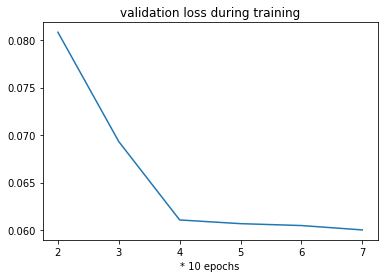

In [88]:
length = len(validation_losses[:])
plt.plot(validation_losses[:])
plt.xticks(np.arange(length), (np.arange(length)+2))
plt.title("validation loss during training")
plt.xlabel("* 10 epochs")

print()

In [100]:
predictions = mlp_model.predict(X)[0]
processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [74,50] rhs shape= [13,50]
	 [[Node: save/Assign_1 = Assign[T=DT_FLOAT, _class=["loc:@hidden_w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](hidden_w, save/RestoreV2_1)]]

Caused by op 'save/Assign_1', defined at:
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-100-ebdf79149b1f>", line 1, in <module>
    predictions = mlp_model.predict(X)[0]
  File "/Users/kyojin/Documents/final/predict_amd/new_MLP.py", line 198, in predict
    saver = tf.train.Saver()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 414, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [74,50] rhs shape= [13,50]
	 [[Node: save/Assign_1 = Assign[T=DT_FLOAT, _class=["loc:@hidden_w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](hidden_w, save/RestoreV2_1)]]


In [92]:
true = filtered_kwh_list
true = denormalize_array(true, kwh_min, kwh_max)

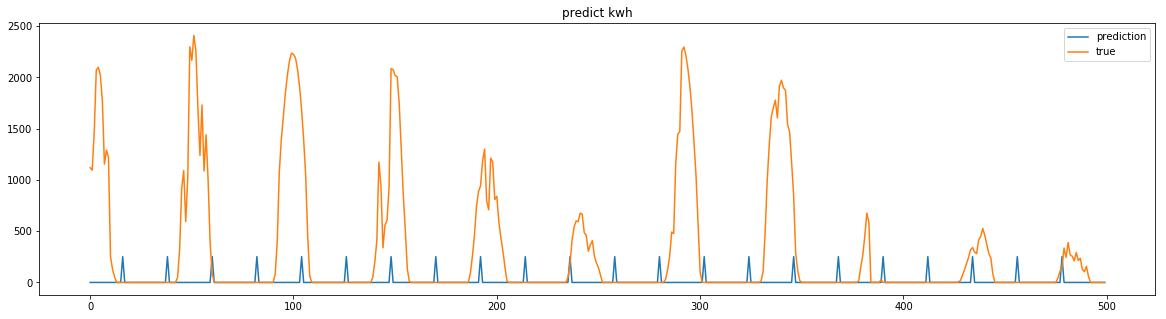

In [93]:
plt.figure(figsize=(20, 5))
plt.plot(processed_prediction[500:1000], label = "prediction")
plt.plot(true[500:1000], label = "true")
plt.legend()
plt.title("predict kwh")

In [94]:
print('training mae :', calc_mae(processed_prediction, true))

IndexError: index 70128 is out of bounds for axis 0 with size 70128

In [95]:
validation = mlp_model.predict(mlp_model.X_val)[0]
processed_validation = process_output_data(validation)
processed_validation = denormalize_array(processed_validation, kwh_min, kwh_max)

val = process_output_data(mlp_model.Y_val)
val = denormalize_array(val, kwh_min, kwh_max)

plt.figure(figsize=(20, 5))
plt.plot(processed_validation[500:1000], label = "prediction")
plt.plot(val[500:1000], label = "true")
plt.legend()
plt.title("predict output")

print('validation mae :', calc_mae(processed_validation, val))

validation mae : 28.7227997678


In [99]:
predictions = mlp_model.predict(all_X)[0]
processed_prediction = process_output_data(predictions)
processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)

In [200]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [201]:
# 2012/01/02 00:00 ~ 2015/12/31 23:30の予測データを書き出す
predict_data[model_name] = np.append(processed_prediction[48:-1], processed_prediction[-1])

In [202]:
predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [207]:
# X_predictによる予測
predictions = mlp_model.predict(X_predict)[0]
processed_prediction = process_output_data(predictions)
processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)

In [81]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [82]:
# 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
predict_data[model_name] = processed_prediction

In [83]:
predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [ ]:
# いろんなエポックのやつをまとめて学習して保存するやつ
'''
epochs = [500, 1000, 2000, 3000, 4000]
for epoch in epochs:
    
    model_name = "targetplace_"+str(target_place)+"_kwh_all_wfc_month_one_layer_hidden_50_"+str(epoch)
    
    try:
        os.mkdir('./data/model/'+model_name)
        print("make save directory")
    except :
        print("directory already exists")

    print(model_name) 
    
    mlp_model = MLP.MLP(X, KWH, epochs = epoch, hidden_size = 50, batch_size = 100, model_name = model_name)
    
    mlp_model.train()
    
    predictions = mlp_model.predict(all_X)[0]
    predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
    processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)
    
    try:
        predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
    except FileNotFoundError:
        s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
        e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
        predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
        predict_data.index = np.arange(len(predict_data))
        predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
    
    # 2012/01/02 00:00 ~ 2015/12/31 23:30の予測データを書き出す
    predict_data[model_name] = np.append(processed_prediction[48:-1], processed_prediction[-1])
    
    # X_predictによる予測
    predictions = mlp_model.predict(X_predict)[0]
    predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1])
    processed_prediction = denormalize_array(predictions, kwh_min, kwh_max)
    
    try:
        predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
    except FileNotFoundError:
        s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
        e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
        predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
        predict_data.index = np.arange(len(predict_data))
        predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
    
    # 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
    predict_data[model_name] = processed_prediction
    
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
'''    

In [88]:
# いろんな活性化関数を比べるためのやつ
'''
t_maes = []
v_maes = []

for i in range(5):
    X_train, X_val, Y_train, Y_val = train_test_split(X, KWH, test_size=0.33)
    mlp_model = MLP(X_train, Y_train, X_val, Y_val, epochs = epochs, hidden_size = hidden_size, batch_size = 100, model_name = model_name, activation = activation)
    mlp_model.train()
    
    predictions = mlp_model.predict(X)[0]
    processed_prediction = process_output_data(predictions)
    processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)
    
    true = process_output_data(filtered_kwh_list)
    true = denormalize_array(true, kwh_min, kwh_max)
    
    t_maes.append(calc_mae(processed_prediction, true))
    
    validation = mlp_model.predict(mlp_model.X_val)[0]
    processed_validation = process_output_data(validation)
    processed_validation = denormalize_array(processed_validation, kwh_min, kwh_max)
    
    val = process_output_data(mlp_model.Y_val)
    val = denormalize_array(val, kwh_min, kwh_max)
    
    v_maes.append(calc_mae(processed_validation, val))
'''
print()

In [26]:
# kfoldsでやるやつ

epochs = 1000
hidden_size = 100
activation = "sigmoid"

t_maes = []
v_maes = []
i = 0
n_splits = 5

for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = KWH[train_idx]
    X_val = X[test_idx]
    Y_val = KWH[test_idx]
    
    i += 1
    model_name = "targetplace_"+str(target_place)+"_limited_scaled_kwh_all_wfc_"+activation
    model_name += "_hidden_"+str(hidden_size)+"_"+str(epochs)
    model_name += "_"+str(i)+"-"+str(n_splits)+"folds"
    
    try:
        os.mkdir('./data/model/'+model_name)
        print("make save directory")
    except :
        print("directory already exists")

    print(model_name)
    
    mlp_model = MLP(X_train, Y_train, X_val, Y_val, epochs = epochs, hidden_size = hidden_size, batch_size = 100, model_name = model_name, activation = activation)

    # train
    mlp_model.train()
    
    # cal train mae
    predictions = mlp_model.predict(X)[0]
    processed_prediction = process_output_data(predictions)
    processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)
    
    true = process_output_data(filtered_kwh_list)
    true = denormalize_array(true, kwh_min, kwh_max)
    
    t_maes.append(calc_mae(processed_prediction, true))
    
    # calc validation mae
    validation = mlp_model.predict(mlp_model.X_val)[0]
    processed_validation = process_output_data(validation)
    processed_validation = denormalize_array(processed_validation, kwh_min, kwh_max)
    
    Y_val = process_output_data(mlp_model.Y_val)
    Y_val = denormalize_array(Y_val, kwh_min, kwh_max)
    
    v_maes.append(calc_mae(processed_validation, Y_val))
    
    # make train prediction data for stacking
    predictions = mlp_model.predict(all_X)[0]
    processed_prediction = process_output_data(predictions)
    processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)
    
    try:
        predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
    except FileNotFoundError:
        s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
        e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
        predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
        predict_data.index = np.arange(len(predict_data))
        predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
        
    # 2012/01/02 00:00 ~ 2015/12/31 23:30の予測データを書き出す
    predict_data[model_name] = np.append(processed_prediction[48:-1], processed_prediction[-1])
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
    
    # X_predictによる予測
    predictions = mlp_model.predict(X_predict)[0]
    processed_prediction = process_output_data(predictions)
    processed_prediction = denormalize_array(processed_prediction, kwh_min, kwh_max)
    
    try:
        predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')
    
    except FileNotFoundError:
        s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
        e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
        predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
        predict_data.index = np.arange(len(predict_data))
        predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)
    
    # 2016/01/01 00:00 ~ 2017/3/31 23:30の予測データを書き出す
    predict_data[model_name] = processed_prediction
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

print()

directory already exists
targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_1-5folds
train#0, validation loss: 5.170228e-01
train#20, validation loss: 6.287920e-02
train#40, validation loss: 3.752839e-02
train#60, validation loss: 2.986040e-02
train#80, validation loss: 2.224399e-02
train#100, validation loss: 2.045428e-02
train#120, validation loss: 1.962069e-02
train#140, validation loss: 1.897544e-02
train#160, validation loss: 1.879786e-02
train#180, validation loss: 1.872276e-02
train#200, validation loss: 1.907663e-02
do early stopping
directory already exists
targetplace_1_limited_scaled_kwh_all_wfc_sigmoid_hidden_100_1000_2-5folds
train#0, validation loss: 8.245469e-01
train#20, validation loss: 5.969308e-02
train#40, validation loss: 3.417460e-02
train#60, validation loss: 2.560950e-02
train#80, validation loss: 2.025308e-02
train#100, validation loss: 1.863313e-02
train#120, validation loss: 1.710314e-02
train#140, validation loss: 1.652989e-02
train#160, valida

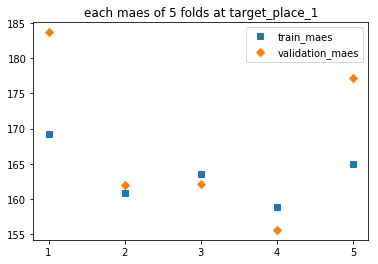

In [27]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'D', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

print()